# <header>**Baseline model for Automated Essay Scoring competition**</header>

*Version 0.1*

In [1]:
!pip install torchview
!pip install torchinfo

# Utils

In [2]:
import random
from kaggle_secrets import UserSecretsClient
import wandb
import os
import datetime
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from string import punctuation, printable
import re

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score

import torch
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
from torchview import draw_graph
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR
from transformers import AutoModel, AutoTokenizer

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

user_secrets = UserSecretsClient()
wandb_api = user_secrets.get_secret("wandb_ha")

wandb.login(key=wandb_api)


random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)

cpu


wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [3]:
model_path = 'allenai/longformer-base-4096'
tokenizer = AutoTokenizer.from_pretrained(model_path)
embedder = AutoModel.from_pretrained(model_path)

config.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/597M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [4]:
ling_features = ['num_words', 'num_punctuations', 'num_nouns',
                 'num_verbs', 'num_adverbs', 'num_conjunctions',
                 'num_distinct_words', 'num_misspell',
                 'mean_word_len', 'num_sentences', 'mean_sent_len']

In [5]:
data_dir = "/kaggle/input/deep-essay-scoring"
train_data = pd.read_csv(os.path.join(data_dir, 'train_linguistic.csv'))
extra_data = pd.read_csv(os.path.join(data_dir, 'extra_linguistic.csv'))

train_data = train_data.dropna(subset=['full_text'])
extra_data = extra_data.dropna(subset=['full_text'])

train_data = train_data[['essay_id', 'full_text', 'score'] + ling_features]
extra_data = extra_data[['essay_id', 'full_text', 'score'] + ling_features]

extra_data = extra_data[~extra_data['full_text'].isin(train_data['full_text'])]

print(train_data.shape, extra_data.shape)

train_data.sample(5)

(17307, 14) (13125, 14)


,essay_id,full_text,score,num_words,num_punctuations,num_nouns,num_verbs,num_adverbs,num_conjunctions,num_distinct_words,num_misspell,mean_word_len,num_sentences,mean_sent_len
12696,bb4c434,"People tend to use there cars so much, they ba...",3,616,36,113,81,43,26,211,20,3.905263,26,113.076923
4625,44e88b0,Imagine being a top scientist at NASA and Viki...,3,432,58,93,40,12,10,180,8,4.342391,22,94.954545
733,0ba78ec,The face of Mars could not be created by alien...,3,244,17,46,15,13,9,114,5,4.267857,12,101.583333
16885,f96c287,Many people belive that the face on Mars was c...,3,273,26,53,29,10,6,163,26,4.290984,13,104.461538
3334,317173f,Driverless Cars are coming soon or later? Peop...,4,649,38,114,83,29,39,168,8,4.028099,31,100.129032


In [7]:
def preprocess(text):
    # text = text.lower()
    text = re.sub(r'\s+', ' ', text)
    text = ''.join([c for c in text if c in printable])
    text = text.strip()
    return text


train_data['full_text'] = train_data['full_text'].apply(preprocess)
extra_data['full_text'] = extra_data['full_text'].apply(preprocess)

train_data.sample(5)

,essay_id,full_text,score,num_words,num_punctuations,num_nouns,num_verbs,num_adverbs,num_conjunctions,num_distinct_words,num_misspell,mean_word_len,num_sentences,mean_sent_len
13112,c0d4f9b,Venus is a dangerous but why should that stop ...,3,275,22,29,42,11,13,131,5,3.980000,15,88.733333
5285,4eed718,"""Are driverless cars coming?"" I'm against driv...",4,543,58,117,65,25,13,187,16,4.051867,25,103.560000
11195,a4ff59c,Have you ever wondered what it would be like t...,3,289,26,52,26,18,4,132,9,4.436782,13,114.461538
6760,650449d,The face of Mars is a landform that looks just...,3,335,25,52,36,30,9,104,5,3.811075,15,102.533333
3451,3310eaf,studying venus is something that you would hav...,1,260,8,56,27,7,17,112,9,4.105469,5,266.800000


Split train, val, test set

In [10]:
extra_ids = extra_data['essay_id'].values

total_len = len(train_data) + len(extra_data)

train_ratio, val_ratio, test_ratio = 0.8, 0.1, 0.1

train_len = int(total_len * train_ratio)
train_df = pd.concat([train_data, extra_data.sample(
    train_len - len(train_data), random_state=random_seed)], ignore_index=True)
train_df = train_df.reset_index(drop=True)

val_len = int(total_len * val_ratio)
val_df = extra_data[~extra_data['essay_id'].isin(
    train_df['essay_id'])].sample(val_len, random_state=random_seed)
val_df = val_df.reset_index(drop=True)

test_df = extra_data[~extra_data['essay_id'].isin(
    set(val_df['essay_id']).union(set(train_df['essay_id'])))]
test_df = test_df.reset_index(drop=True)

print(train_df.shape, val_df.shape, test_df.shape)

(24345, 14) (3043, 14) (3043, 14)


Hyperparameters

In [11]:
hyperparameters = {
    'lr': 5e-4,
    'dropout': 0.2,
    'epochs': 5,
    'batch_size': 36,
    'embedding_model': model_path,
    'train_set': {
        'total': len(train_df),
        'ratio': train_ratio,
    },
    'val_set': {
        'total': len(val_df),
        'ratio': val_ratio,
    },
    'test_set': {
        'total': len(test_df),
        'ratio': test_ratio,
    },
    'linguistic_features': ling_features,
    'accelator': str(device)
}

In [12]:
train_tokenized = tokenizer(train_df['full_text'].tolist(),
                            padding=True, truncation=False, return_tensors="np")

train_df['input_ids'] = train_tokenized['input_ids'].tolist()
train_df['attention_mask'] = train_tokenized['attention_mask'].tolist()

hyperparameters['max_seq_len'] = train_tokenized['input_ids'].shape[1]
print(hyperparameters['max_seq_len'])

print(len(train_df.sample(1).iloc[0]['input_ids']))

1850
1850


In [13]:
val_tokenized = tokenizer(val_df['full_text'].tolist(),
                          max_length=hyperparameters['max_seq_len'], padding='max_length',
                          truncation=True, return_tensors="pt")

val_df['input_ids'] = val_tokenized['input_ids'].tolist()
val_df['attention_mask'] = val_tokenized['attention_mask'].tolist()

print(len(val_df.sample(1).iloc[0]['input_ids']))

test_tokenized = tokenizer(test_df['full_text'].tolist(),
                           max_length=hyperparameters['max_seq_len'], padding='max_length',
                           truncation=True, return_tensors="pt")

test_df['input_ids'] = test_tokenized['input_ids'].tolist()
test_df['attention_mask'] = test_tokenized['attention_mask'].tolist()

print(len(test_df.sample(1).iloc[0]['input_ids']))

1850
1850


In [14]:
class MultiFeaturesDataset(Dataset):
    def __init__(self, df: pd.DataFrame):
        # self.text = df['clean_text'].values
        self.token_ids = df['input_ids'].values
        self.attention_mask = df['attention_mask'].values
        self.score = df['score'].values
        self.ling_features = []
        for feature in ling_features:
            self.ling_features.append(df[feature].values)

    def __len__(self):
        return len(self.score)

    def __getitem__(self, idx):
        features = []
        for feature in self.ling_features:
            features.append(feature[idx])

        features = torch.tensor(features, dtype=torch.float)

        score = torch.reshape(torch.tensor(
            self.score[idx], dtype=torch.float), (1,))

        return torch.tensor(self.token_ids[idx]), torch.tensor(self.attention_mask[idx]), features, score


train_dataset = MultiFeaturesDataset(train_df)
val_dataset = MultiFeaturesDataset(val_df)
test_dataset = MultiFeaturesDataset(test_df)

In [15]:
train_dataloader = DataLoader(
    train_dataset, batch_size=hyperparameters['batch_size'], shuffle=True)
val_dataloader = DataLoader(
    val_dataset, batch_size=hyperparameters['batch_size'], shuffle=True)
test_dataloader = DataLoader(
    test_dataset, batch_size=hyperparameters['batch_size'], shuffle=True)

for token_ids, attention_mask, features, score in train_dataloader:
    print(token_ids.shape, attention_mask.shape, features.shape, score.shape)
    break

torch.Size([36, 1850]) torch.Size([36, 1850]) torch.Size([36, 11]) torch.Size([36, 1])


In [16]:
class MultiFeaturesModel(torch.nn.Module):
    def __init__(self, embedder,
                 ling_features_input_size, ling_features_hidden_size=64,
                 dropout=0.2):
        super(MultiFeaturesModel, self).__init__()
        # freeze
        for param in embedder.parameters():
            param.requires_grad = False
        self.ling_features = torch.nn.Linear(
            ling_features_input_size, ling_features_hidden_size)
        self.regressor = torch.nn.Linear(
            ling_features_hidden_size + embedder.config.hidden_size, 1)
        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, token_ids, attention_mask, ling_features):
        embedded = self.embedder(
            token_ids, attention_mask=attention_mask).last_hidden_state[:, 0, :]
        embedded = self.dropout(embedded)
        ling_features = torch.relu(self.ling_features(ling_features))
        ling_features = self.dropout(ling_features)
        features = torch.cat((embedded, ling_features), dim=1)
        score = self.regressor(features)
        return score


model = MultiFeaturesModel(embedder, len(
    ling_features), 32, dropout=hyperparameters['dropout'])

inputs = next(iter(train_dataloader))[:-1]
model_summary = summary(model, input_data=inputs)

model_summary

Input ids are automatically padded from 1850 to 2048 to be a multiple of `config.attention_window`: 512


Layer (type:depth-idx)                                       Output Shape              Param #
MultiFeaturesModel                                           [36, 1]                   --
├─LongformerModel: 1-1                                       [36, 768]                 --
│    └─LongformerEmbeddings: 2-1                             [36, 2048, 768]           --
│    │    └─Embedding: 3-1                                   [36, 2048, 768]           (38,603,520)
│    │    └─Embedding: 3-2                                   [36, 2048, 768]           (3,147,264)
│    │    └─Embedding: 3-3                                   [36, 2048, 768]           (768)
│    │    └─LayerNorm: 3-4                                   [36, 2048, 768]           (1,536)
│    │    └─Dropout: 3-5                                     [36, 2048, 768]           --
│    └─LongformerEncoder: 2-2                                [36, 1850, 768]           --
│    │    └─ModuleList: 3-6                                  --     

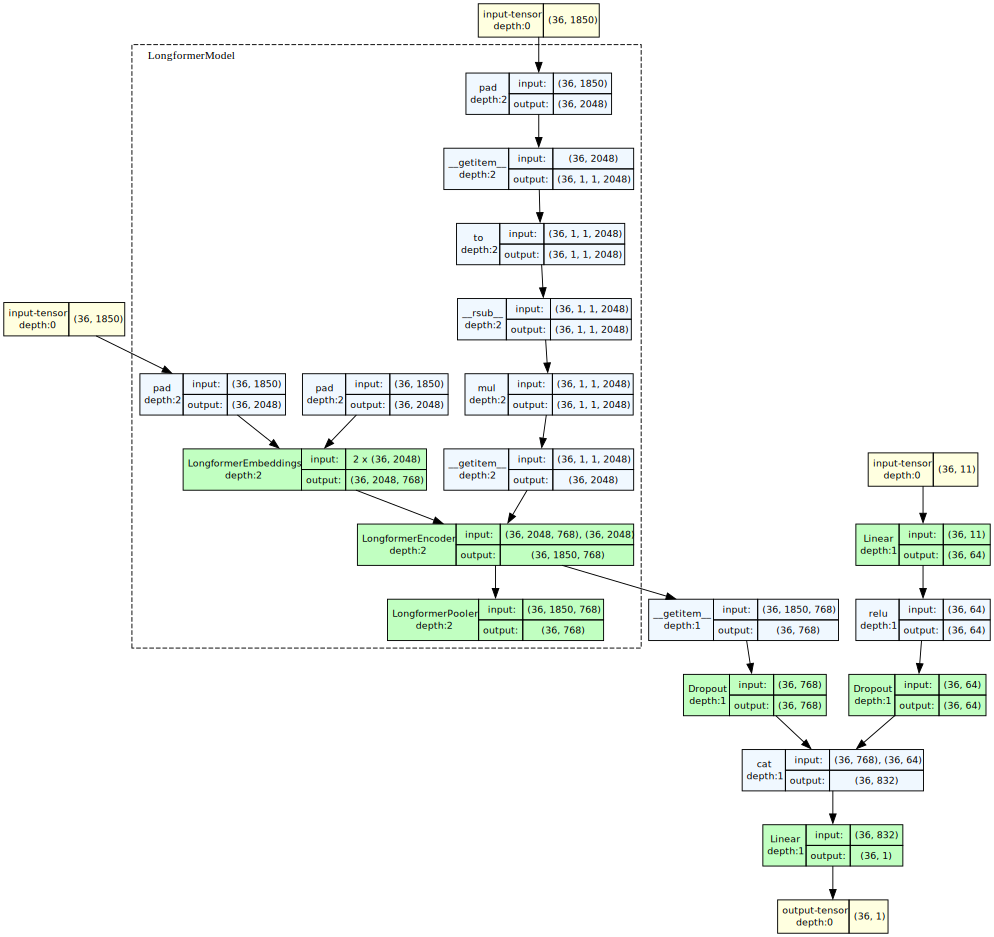

In [17]:
model_graph = draw_graph(model,
                         input_data=inputs,
                         expand_nested=True,
                         depth=2)
model_graph.visual_graph

In [18]:
def train(model, optimizer, criterion, train_dataloader, logging_steps=10):
    model.train()
    running_loss = 0.0
    optimizer.zero_grad()

    for i, (token_ids, attention_mask, features, score) in enumerate(train_dataloader):
        optimizer.zero_grad()
        output = model(token_ids.to(device), attention_mask.to(
            device), features.to(device))
        loss = criterion(output, score.to(device)).float()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        if (i+1) % logging_steps == 0:
            wandb.log({'train_loss': running_loss / (i+1)})
            print(
                f'Batch {i+1}/{len(train_dataloader)} Loss: {running_loss / (i+1)}', end='\r')

    return running_loss / len(train_dataloader)


def evaluate(model, criterion, dataloader):
    model.eval()
    running_loss = 0.0
    all_predictions = []
    all_scores = []

    with torch.no_grad():
        for token_ids, attention_mask, features, score in dataloader:
            output = model(token_ids.to(device), attention_mask.to(
                device), features.to(device))
            loss = criterion(output, score.to(device))
            kappa = cohen_kappa_score(np.round(
                output.cpu().numpy()), np.round(score.cpu().numpy()))
            running_loss += loss.item()
            all_predictions.extend(output.cpu().numpy())
            all_scores.extend(score.cpu().numpy())

    return running_loss / len(dataloader), np.array(all_predictions), np.array(all_scores)

In [19]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [50]:
critierion = torch.nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(),
                              lr=hyperparameters['lr'])
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)
early_stopper = EarlyStopper(patience=3, min_delta=1e-2)

train_losses, val_losses, val_kappa_scores = [], [], []

hyperparameters['early_stopper'] = early_stopper.__dict__
hyperparameters['model'] = dict(model.__dict__['_modules'])

hyperparameters

{'lr': 0.0005,
 'dropout': 0.2,
 'epochs': 5,
 'batch_size': 36,
 'embedding_model': 'allenai/longformer-base-4096',
 'train_set': {'total': 24345, 'ratio': 0.8},
 'val_set': {'total': 3043, 'ratio': 0.1},
 'test_set': {'total': 3043, 'ratio': 0.1},
 'linguistic_features': ['num_words',
  'num_punctuations',
  'num_nouns',
  'num_verbs',
  'num_adverbs',
  'num_conjunctions',
  'num_distinct_words',
  'num_misspell',
  'mean_word_len',
  'num_sentences',
  'mean_sent_len'],
 'accelator': 'cpu',
 'max_seq_len': 1850,
 'early_stopper': {'patience': 3,
  'min_delta': 0.01,
  'counter': 0,
  'min_validation_loss': inf},
 'model': {'embedder': LongformerModel(
    (embeddings): LongformerEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (position_embeddings): Embedding(4098, 768, padding_idx=1)


In [19]:
torch.cuda.empty_cache()

In [ ]:
wandb.init(project='deep-essay-scoring', config=hyperparameters)

for epoch in range(hyperparameters['epochs']):
    train_loss = train(model, optimizer, critierion, train_dataloader)
    val_loss, val_predictions, val_scores = evaluate(
        model, critierion, val_dataloader)

    val_kappa = cohen_kappa_score(
        np.round(val_predictions), val_scores, weights='quadratic')

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_kappa_scores.append(val_kappa)

    scheduler.step()

    wandb.log({'train_loss': train_loss, 'val_loss': val_loss,
              'val_kappa': val_kappa, 'epoch': epoch+1,
               'learning_rate': optimizer.param_groups[0]['lr']})

    print(
        f'Epoch: {epoch+1}, Train Loss: {train_loss}, Val Loss: {val_loss}, Val Kappa: {val_kappa}')
    if early_stopper.early_stop(val_losses[-1]):
        break

wandb: Currently logged in as: minha-lehoang. Use `wandb login --relogin` to force relogin


In [21]:
# Get current date and time
now = datetime.datetime.now()
now_str = now.strftime("%Y-%m-%d_%H-%M")

embedder_name = model_path.split('/')[-1]
model_name = f'multi_features_{embedder_name}_model_{now_str}'

# Save the model
with open(f'{model_name}_summary.text', 'w') as f:
    f.write(str(model_summary))

torch.save(model.state_dict(), f'{model_name}.pth')

# Save the hyperparameters
with open(f'{model_name}_hyperparameters.json', 'w') as f:
    json.dump(hyperparameters, f)

SyntaxError: f-string: unmatched '(' (30096237.py, line 6)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
def inference(model, dataloader):
    model.eval()
    all_predictions = []

    with torch.no_grad():
        for token_ids, attention_mask, features, score in dataloader:
            output = model(token_ids.to(device), attention_mask.to(
                device), features.to(device))
            all_predictions.extend(output.cpu().numpy())

    return np.array(all_predictions)


test_predictions = inference(model, test_dataloader)

test_kappa = cohen_kappa_score(
    np.round(test_predictions), test_df['score'].values, weights='quadratic')

test_df['prediction'] = test_predictions

test_df[['essay_id', 'score', 'prediction']].to_csv('test_predictions.csv')

test_df[['essay_id', 'score', 'prediction']]